## Environment

In [1]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm
from x_transformers import ContinuousTransformerWrapper, Encoder
from matplotlib import pyplot as plt

env = gym.make("CartPole-v1")


def play(n_steps: int = 1000, state_size: int = 6) -> np.ndarray:
    env.reset()
    terminated = False
    train_data = np.empty((n_steps, state_size))
    for i in range(n_steps):
        if terminated:
            observation, _ = env.reset()
            terminated = False
            reward = 0
            action = 0
        else:
            action = env.action_space.sample()  # Random action
            observation, reward, terminated, _, _ = env.step(action)
        train_data[i] = np.append(observation.ravel(), [reward, action])

    return train_data


class ObservationDataset(Dataset):
    def __init__(self, observations, y):
        self.observations = torch.tensor(observations, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.observations)

    def __getitem__(self, idx) -> tuple[torch.Tensor, torch.Tensor]:
        return self.observations[idx], self.y[idx]


device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = "mps"
batch_size = 128
input_size = 6  # State + action + reward
out_size = 5  # No action
data = play(2**18, input_size)
data = (data - data.mean(0)) / data.std()

dataset = ObservationDataset(data[:-1], data[1:])
dataloader = DataLoader(dataset, batch_size, shuffle=True)

## Standard prediction

In [2]:
def train_no_diffusion(model, dataloader, use_dy=True):
    loss_fn = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=3e-5)
    pbar = tqdm(dataloader)
    losses = []
    for x, y in pbar:
        x = x.to(device)
        y = y.to(device)
        with torch.no_grad():
            if use_dy:
                dy = y - x
                objective = dy
            else:
                objective = y

        y_pred = model(x.unsqueeze(2))[:, :out_size, 0]
        loss = loss_fn(objective[:, :out_size], y_pred)
        losses.append(loss.cpu().detach().item())
        loss.backward()
        pbar.set_description(f"Loss: {loss:.3f}")
        optimizer.step()
        optimizer.zero_grad()
    return losses


model = ContinuousTransformerWrapper(
    max_seq_len=input_size,  # Patches
    dim_in=1,  # In Patch pixels
    dim_out=1,  # Out Patch pixels
    emb_dim=256,
    attn_layers=Encoder(dim=256, depth=6, heads=8, attn_flash=True),
).to(device)
number_of_parameters = sum(p.numel() for p in model.parameters())
print(f"number_of_parameters: {number_of_parameters}")
losses = train_no_diffusion(model, dataloader, use_dy=True)

number_of_parameters: 6304512


  0%|          | 0/2048 [00:00<?, ?it/s]

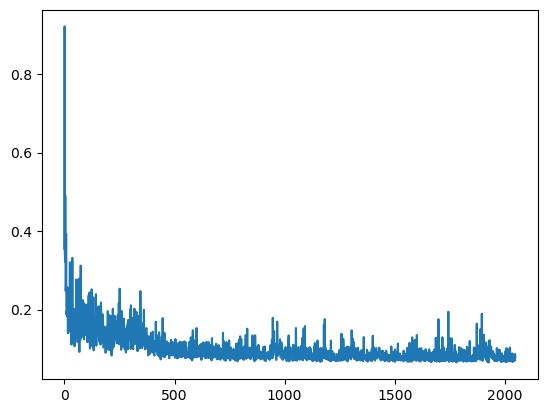

: 

In [3]:
plt.plot(losses)

In [5]:
np.mean(losses[-200:])

0.08592780105769635

## Diffusion prediction

In [6]:
model = ContinuousTransformerWrapper(
    max_seq_len=input_size + out_size + 1,  # previous state, noised state, time
    dim_in=1,  # In Patch pixels
    dim_out=1,  # Out Patch pixels
    emb_dim=256,
    attn_layers=Encoder(dim=256, depth=6, heads=8, attn_flash=True),
).to(device)

In [7]:
optimizer = optim.AdamW(model.parameters(), lr=3e-5)
model.train()
pbar = tqdm(dataloader)
losses = []
for cond, x0 in pbar:
    b = x0.size(0)
    cond, x0 = cond.to(device), x0.to(device)[:, :out_size]
    z_1 = torch.randn_like(x0).to(device)
    t = torch.rand(b).to(device).view(-1, 1)
    z_t = (1 - t) * x0 + t * z_1
    model_input = torch.cat([z_t, t, cond], 1).unsqueeze(2)
    v_t = model(model_input)[:, :out_size, 0]

    loss = ((z_1 - x0 - v_t) ** 2).mean()

    # w_t = t / (1 - t)
    # snr_prime_t = -2 / (t * (1 - t))
    # eps_pred = -2 / (snr_prime_t * t) * (v_t + (1 / (1 - t)) * z_t)
    # loss = -1 / (2 * b) * (w_t * snr_prime_t * ((eps_pred - z_1) ** 2)).mean()

    loss.backward()
    losses.append(loss.cpu().detach().item())
    pbar.set_description(f"Loss: {loss:.5f}")
    optimizer.step()
    optimizer.zero_grad()

  0%|          | 0/2048 [00:00<?, ?it/s]

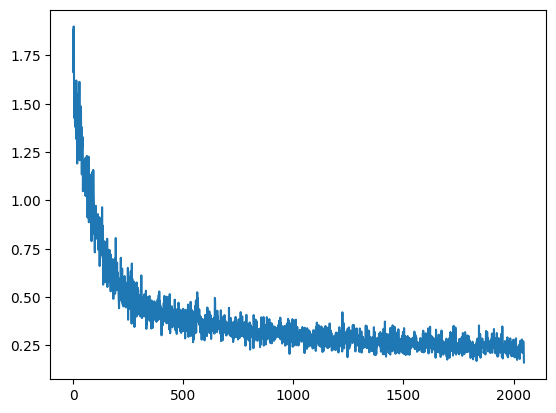

In [8]:
plt.plot(losses)

In [42]:
@torch.no_grad()
def sample(model, z_t, cond, x0, sample_steps=10):
    loss_fn = nn.MSELoss()
    model.eval()
    b = z_t.size(0)
    dt = 1.0 / sample_steps
    dt = torch.tensor([dt] * b).to(z.device).view(-1, 1)

    steps = [z_t]
    for i in range(sample_steps, 0, -1):
        t = i / sample_steps
        t = torch.tensor([t] * b).to(z_t.device)

        model_input = torch.cat([z_t, t.unsqueeze(-1), cond], 1).unsqueeze(2)
        v_t = model(model_input)[:, :out_size, 0]

        z_t = z_t - dt * v_t

        steps.append(z_t)

        print(loss_fn(x0, z_t))
    return steps


cond, x0 = dataset[2**16 : 2**16 + 128]
cond, x0 = cond.to(device), x0.to(device)[:, :out_size]
z = torch.randn_like(x0)
_ = sample(model, z, cond, x0, 20)

tensor(1.3148, device='cuda:0')
tensor(1.1849, device='cuda:0')
tensor(1.0647, device='cuda:0')
tensor(0.9535, device='cuda:0')
tensor(0.8503, device='cuda:0')
tensor(0.7545, device='cuda:0')
tensor(0.6651, device='cuda:0')
tensor(0.5821, device='cuda:0')
tensor(0.5058, device='cuda:0')
tensor(0.4362, device='cuda:0')
tensor(0.3735, device='cuda:0')
tensor(0.3180, device='cuda:0')
tensor(0.2698, device='cuda:0')
tensor(0.2291, device='cuda:0')
tensor(0.1961, device='cuda:0')
tensor(0.1709, device='cuda:0')
tensor(0.1535, device='cuda:0')
tensor(0.1434, device='cuda:0')
tensor(0.1399, device='cuda:0')
tensor(0.1426, device='cuda:0')
